# 네이버 검색어 트렌드

## #01. 작업 준비

### 패키지 참조

In [21]:
import requests
import json
from pandas import DataFrame, to_datetime, merge, melt

import sys
sys.path.append("../../")

import datetime as dt
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sb

from helper import set_datetime_index, exp_time_data

## #02. 네이버 검색어 트렌드 OpenAPI 연동

### 접속에 필요한 정보 설정

#### API URL

In [5]:
API_URL = "https://openapi.naver.com/v1/datalab/search"

### 발급받은 인증키

In [6]:
client_id = "Nwvd7UzAGjX9l5PMpWev"
client_secret = "LGeBJrCudw"

### 접속 객체 생성

In [7]:
session = requests.Session()
session.headers.update({
    "X-Naver-Client-Id": client_id,
    "X-Naver-Client-Secret": client_secret
})

### 접속 시도

#### HTTP GET 방식인 경우
'''python
session.get(API_URL, params={"a" : 100, "b" : 200})
'''

#### HTTP POST 방식인 경우

'''python
session.post(API_URL, data={"a" : 100, "b" : 200})
'''

#### HTTP POST 방식이면서 파라미터를 JSON으로 구성하는 경우(body data 전송)

'''python
session.post(API_URL, data=json.dumps({"a" : 100, "b" : 200}))
'''

### 전달할 검색어 구성

In [8]:
data = {
    "startDate": "2020-01-01",   # 2016년 1월 1일부터 조회 시작 가능
    "endDate": "2023-07-31",
    "timeUnit": "date",         # date: 일간, week: 주간, month: 월간
    "keywordGroups": [
        {
            "groupName": "Benz",  # 검색주제
            "keywords": ["e클래스", "s클래스", "c클래스", "벤츠 cls"]   # 주제와 관련된 검색어
        },
         {
            "groupName": "BMW",  # 검색주제
            "keywords": ["5시리즈", "x5", "x7", "x3"]   # 주제와 관련된 검색어
        },
         {
            "groupName": "AUDI",  # 검색주제
            "keywords": ["a6", "e트론", "a7", "q5"]   # 주제와 관련된 검색어
        }
    ]
}

### 데이터 요청하기

In [9]:
r = session.post(API_URL, data=json.dumps(data))

if r.status_code != 200:
    msg = "[%d Error] %s 에러가 발생함" % (r.status_code, r.reason)
    raise Exception(msg)

r.encoding = "utf-8"
mydict = json.loads(r.text)
mydict

{'startDate': '2020-01-01',
 'endDate': '2023-07-31',
 'timeUnit': 'date',
 'results': [{'title': 'Benz',
   'keywords': ['e클래스', 's클래스', 'c클래스', '벤츠 cls'],
   'data': [{'period': '2020-01-01', 'ratio': 20.47127},
    {'period': '2020-01-02', 'ratio': 17.03877},
    {'period': '2020-01-03', 'ratio': 14.79992},
    {'period': '2020-01-04', 'ratio': 22.4751},
    {'period': '2020-01-05', 'ratio': 23.22963},
    {'period': '2020-01-06', 'ratio': 26.96518},
    {'period': '2020-01-07', 'ratio': 25.30768},
    {'period': '2020-01-08', 'ratio': 25.55507},
    {'period': '2020-01-09', 'ratio': 26.50751},
    {'period': '2020-01-10', 'ratio': 27.05176},
    {'period': '2020-01-11', 'ratio': 25.31387},
    {'period': '2020-01-12', 'ratio': 23.90376},
    {'period': '2020-01-13', 'ratio': 27.10742},
    {'period': '2020-01-14', 'ratio': 29.12363},
    {'period': '2020-01-15', 'ratio': 38.66039},
    {'period': '2020-01-16', 'ratio': 38.32642},
    {'period': '2020-01-17', 'ratio': 19.14156},
   

### 응답 결과 구조

In [10]:
print(' 검색결과수 : ',len(mydict['results']))

 검색결과수 :  3


In [11]:
title1 = mydict['results'][0]['title']
print(title1)

data = mydict['results'][0]['data']
df1 = DataFrame(data)
df1.rename(columns={'ratio':title1}, inplace=True)
df1.head()

Benz


,period,Benz
0,2020-01-01,20.47127
1,2020-01-02,17.03877
2,2020-01-03,14.79992
3,2020-01-04,22.47510
4,2020-01-05,23.22963


In [12]:
title2 = mydict['results'][1]['title']
print(title2)

data2 = mydict['results'][1]['data']
df2 = DataFrame(data2)
df2.rename(columns={'ratio':title2}, inplace=True)
df2.head()

BMW


,period,BMW
0,2020-01-01,17.66343
1,2020-01-02,19.30236
2,2020-01-03,20.17440
3,2020-01-04,19.56830
4,2020-01-05,20.45890


In [13]:
title3 = mydict['results'][2]['title']
print(title3)

data3 = mydict['results'][2]['data']
df3 = DataFrame(data3)
df3.rename(columns={'ratio':title3}, inplace=True)
df3.head()

AUDI


,period,AUDI
0,2020-01-01,13.09914
1,2020-01-02,14.96072
2,2020-01-03,14.27422
3,2020-01-04,14.62675
4,2020-01-05,14.27422


### 생성된 데이터프레임 병합

In [15]:
tmp = merge(df1, df2, how='outer')
df = merge(tmp, df3, how='outer')
df.head()

,period,Benz,BMW,AUDI
0,2020-01-01,20.47127,17.66343,13.09914
1,2020-01-02,17.03877,19.30236,14.96072
2,2020-01-03,14.79992,20.17440,14.27422
3,2020-01-04,22.47510,19.56830,14.62675
4,2020-01-05,23.22963,20.45890,14.27422


## #03. 연동 결과에 대한 시계열 분석

### 데이터 타입 확인

In [16]:
df.dtypes

period     object
Benz      float64
BMW       float64
AUDI      float64
dtype: object

### 날짜 컬럼에 대한 형변환 및 인덱스 설정

In [17]:
df['period'] = to_datetime(df['period'])
df2 = set_datetime_index(df, 'period')
df2

,Benz,BMW,AUDI
2020-01-01,20.47127,17.66343,13.09914
2020-01-02,17.03877,19.30236,14.96072
2020-01-03,14.79992,20.17440,14.27422
2020-01-04,22.47510,19.56830,14.62675
2020-01-05,23.22963,20.45890,14.27422
...,...,...,...
2023-07-27,23.09975,42.83505,12.40027
2023-07-28,25.06648,46.22425,13.38363
2023-07-29,24.99845,46.71903,12.28276
2023-07-30,25.53033,46.91693,11.68903


In [19]:
df3 = df2.reset_index()
df3.head()

,index,Benz,BMW,AUDI
0,2020-01-01,20.47127,17.66343,13.09914
1,2020-01-02,17.03877,19.30236,14.96072
2,2020-01-03,14.79992,20.17440,14.27422
3,2020-01-04,22.47510,19.56830,14.62675
4,2020-01-05,23.22963,20.45890,14.27422


In [22]:
df4 = melt(df3, id_vars=['index'], value_vars=['Benz','BMW','AUDI'], var_name='키워드', value_name='검색량')
df4.set_index('index', inplace=True)
df4.head()

,키워드,검색량
index,,
2020-01-01,Benz,20.47127
2020-01-02,Benz,17.03877
2020-01-03,Benz,14.79992
2020-01-04,Benz,22.47510
2020-01-05,Benz,23.22963


C:\Users\hanjieun_2\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hanjieun_2\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49353 (\N{HANGUL SYLLABLE SAEG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hanjieun_2\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hanjieun_2\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hanjieun_2\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 508

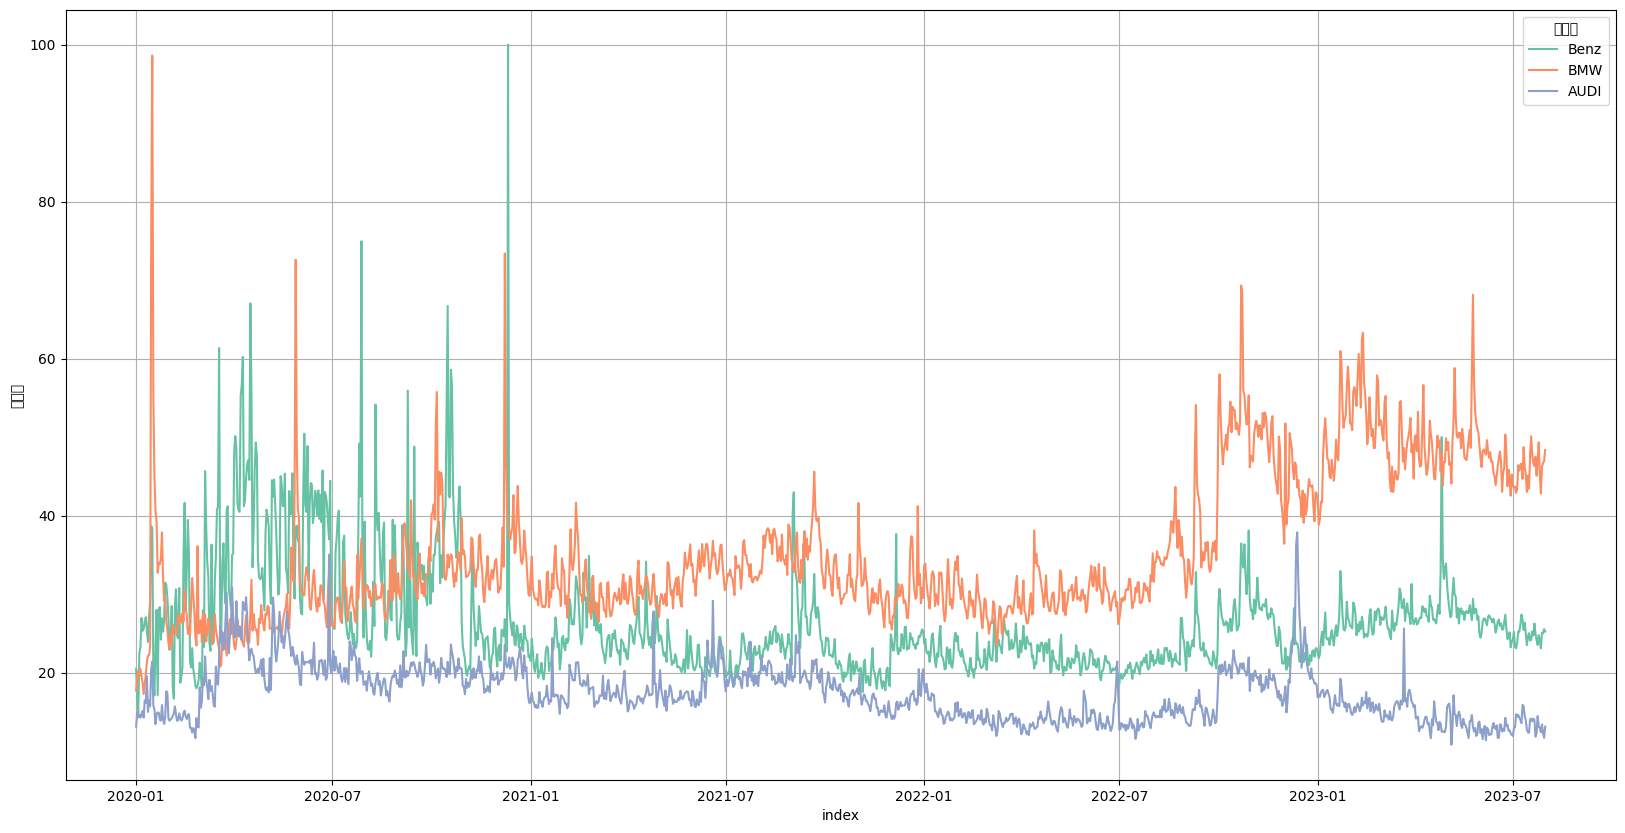

In [23]:
plt.figure(figsize=(20,10))
sb.lineplot(data=df4, y='검색량', x=df4.index, hue='키워드', palette='Set2')
plt.grid()
plt.show()
plt.close()

### helper에 구현된 기능을 활용하여 데이터 검정

Benz
결측치 수 : 0


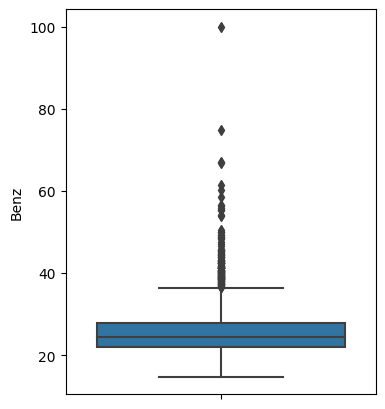

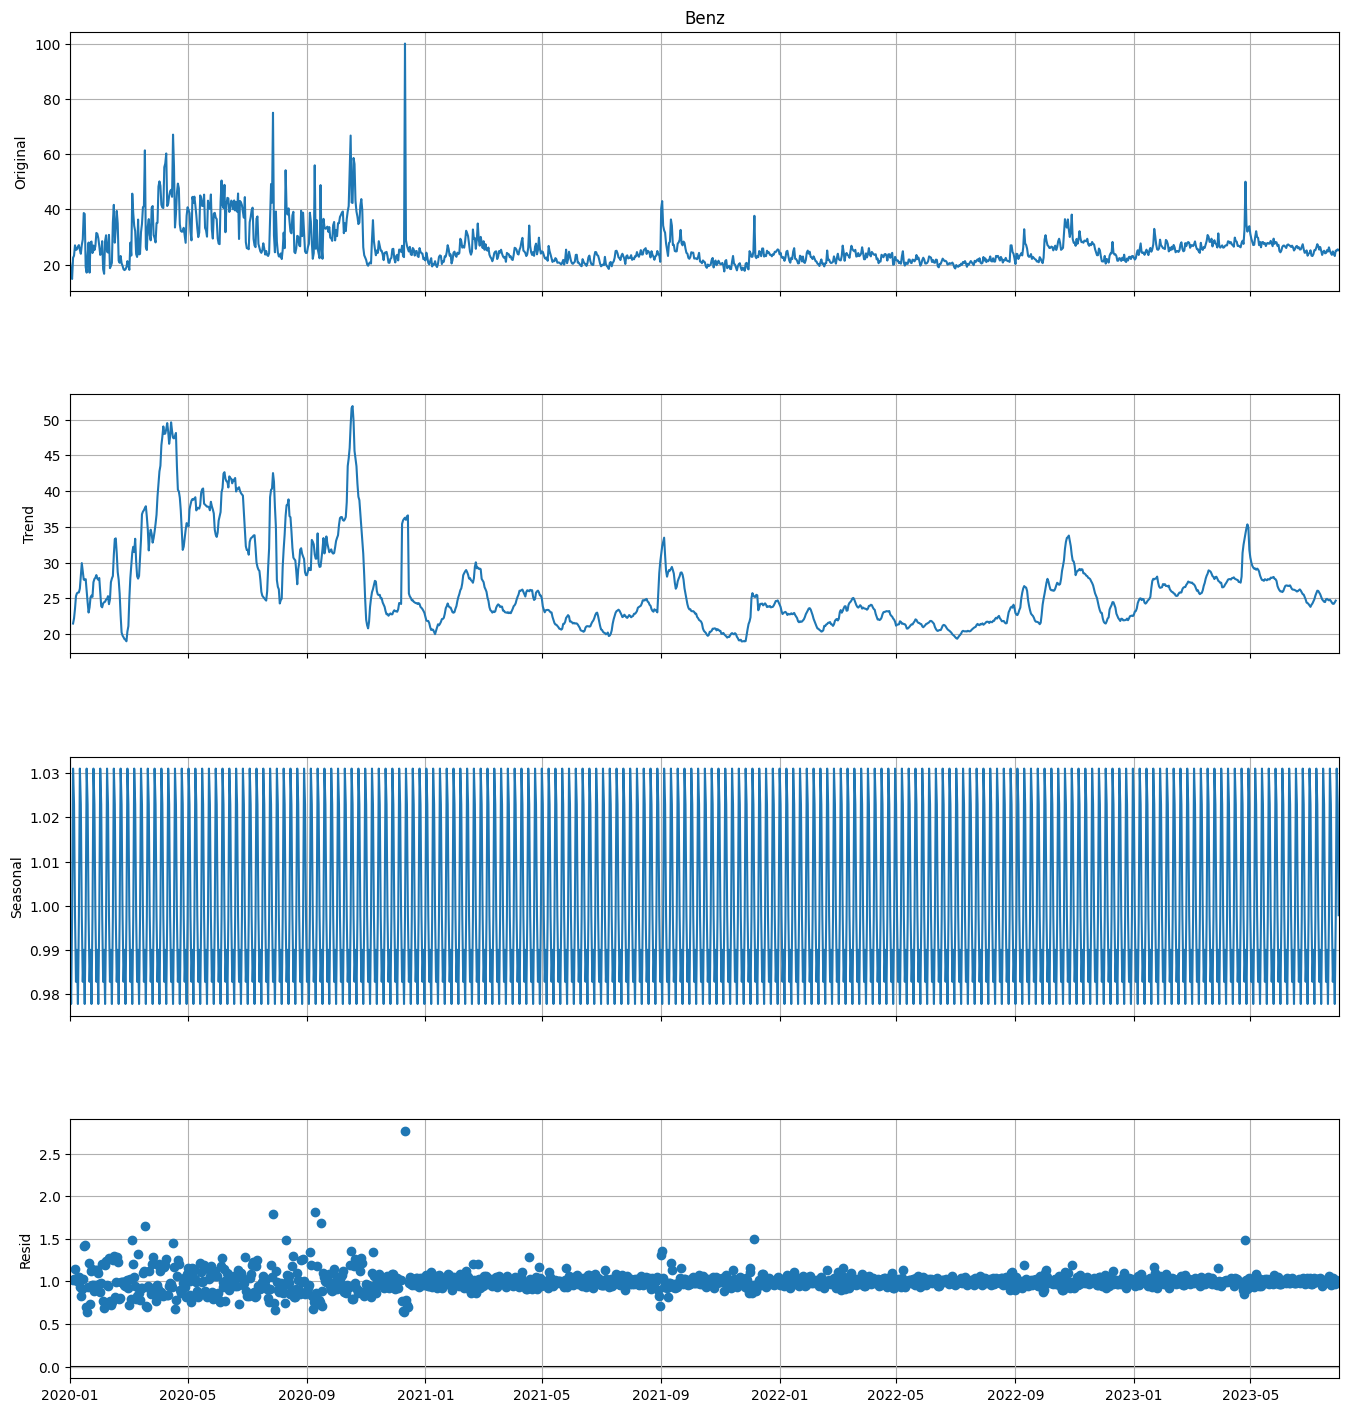

========= 원본 데이터 ===========
+------------------------------------+------------+
| ADF Test                           |            |
|------------------------------------+------------|
| 검정통계량(ADF Statistic)          |   -3.57374 |
| 유의수준(p-value)                  | 0.00628338 |
| 최적차수(num of lags)              |         13 |
| 관측치 개수(num of observations)   |       1294 |
| 기각값(Critical Values) 1%         |   -3.43541 |
| 기각값(Critical Values) 5%         |   -2.86378 |
| 기각값(Critical Values) 10%        |   -2.56796 |
| 데이터 정상성 여부(0=False,1=True) |          1 |
+------------------------------------+------------+


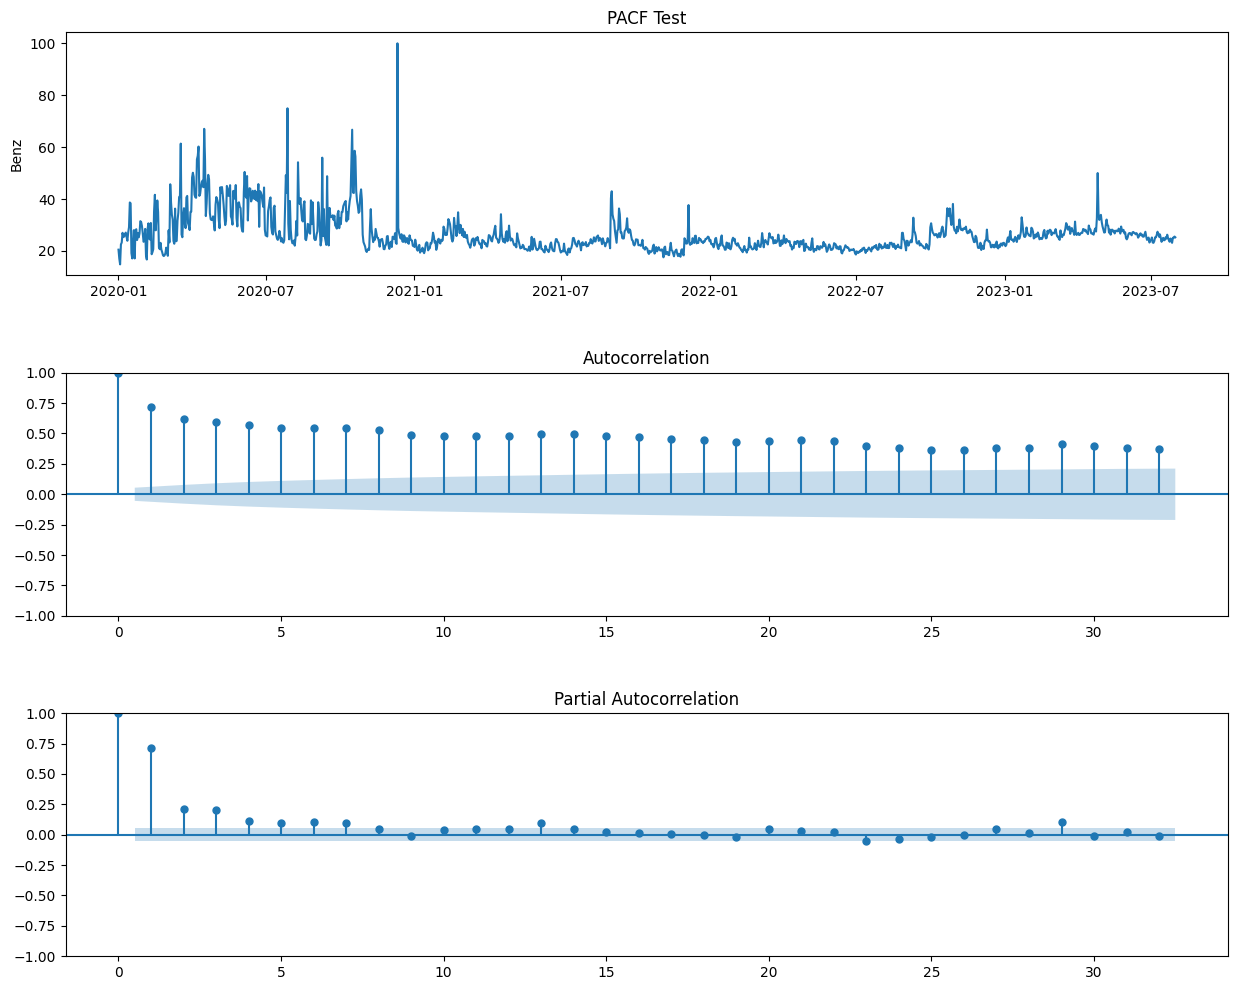

BMW
결측치 수 : 0


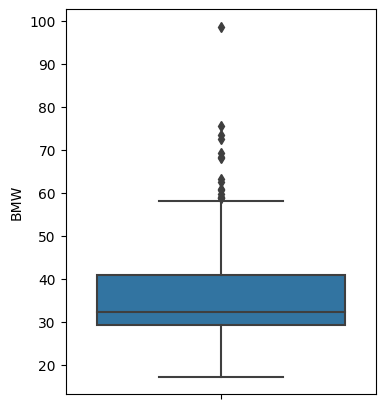

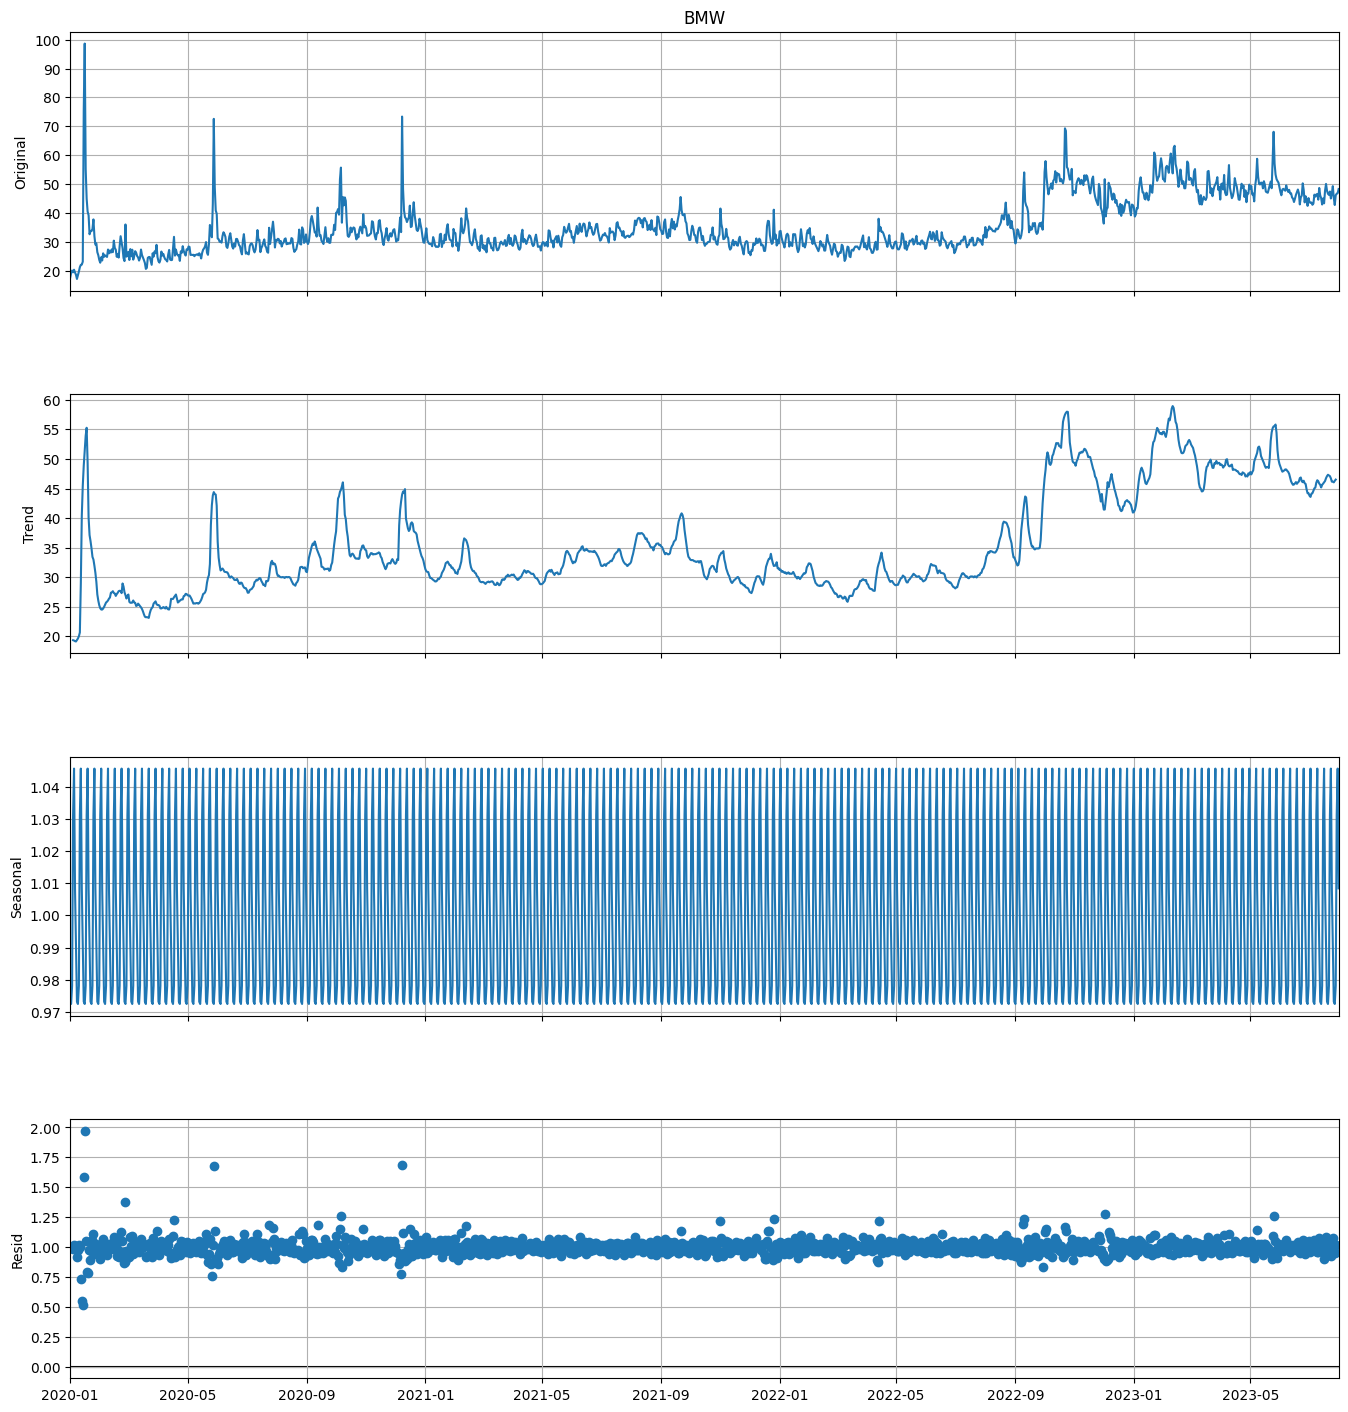

========= 원본 데이터 ===========
+------------------------------------+----------+
| ADF Test                           |          |
|------------------------------------+----------|
| 검정통계량(ADF Statistic)          | -1.63093 |
| 유의수준(p-value)                  | 0.467002 |
| 최적차수(num of lags)              |       21 |
| 관측치 개수(num of observations)   |     1286 |
| 기각값(Critical Values) 1%         | -3.43545 |
| 기각값(Critical Values) 5%         | -2.86379 |
| 기각값(Critical Values) 10%        | -2.56797 |
| 데이터 정상성 여부(0=False,1=True) |        0 |
+------------------------------------+----------+


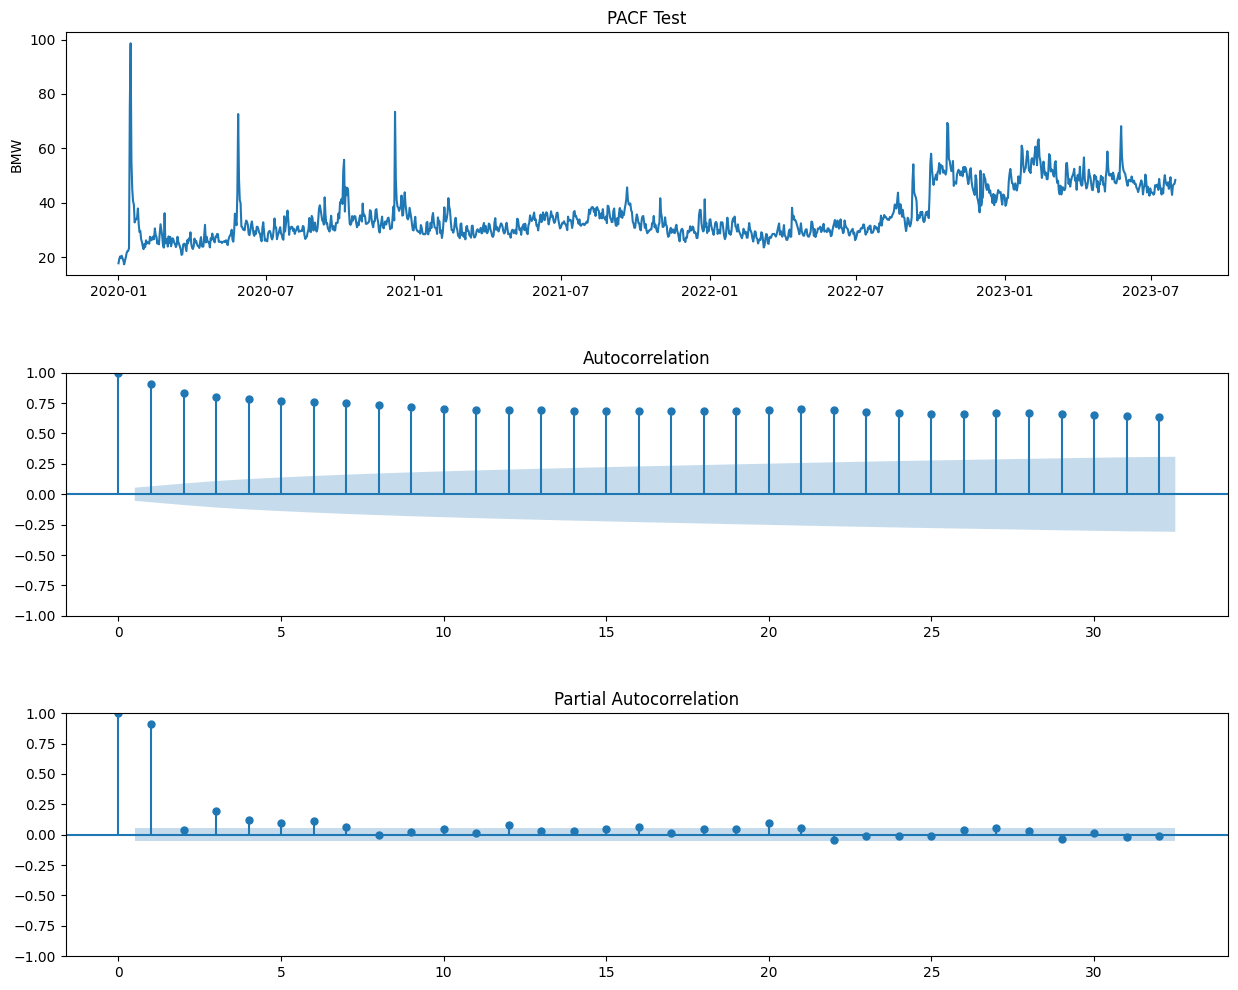

AUDI
결측치 수 : 0


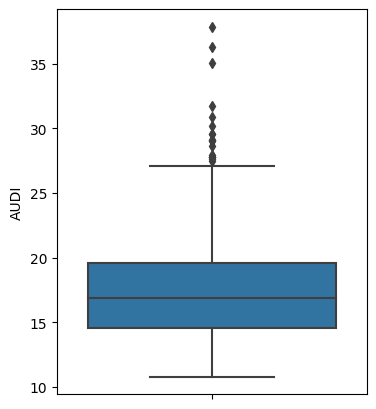

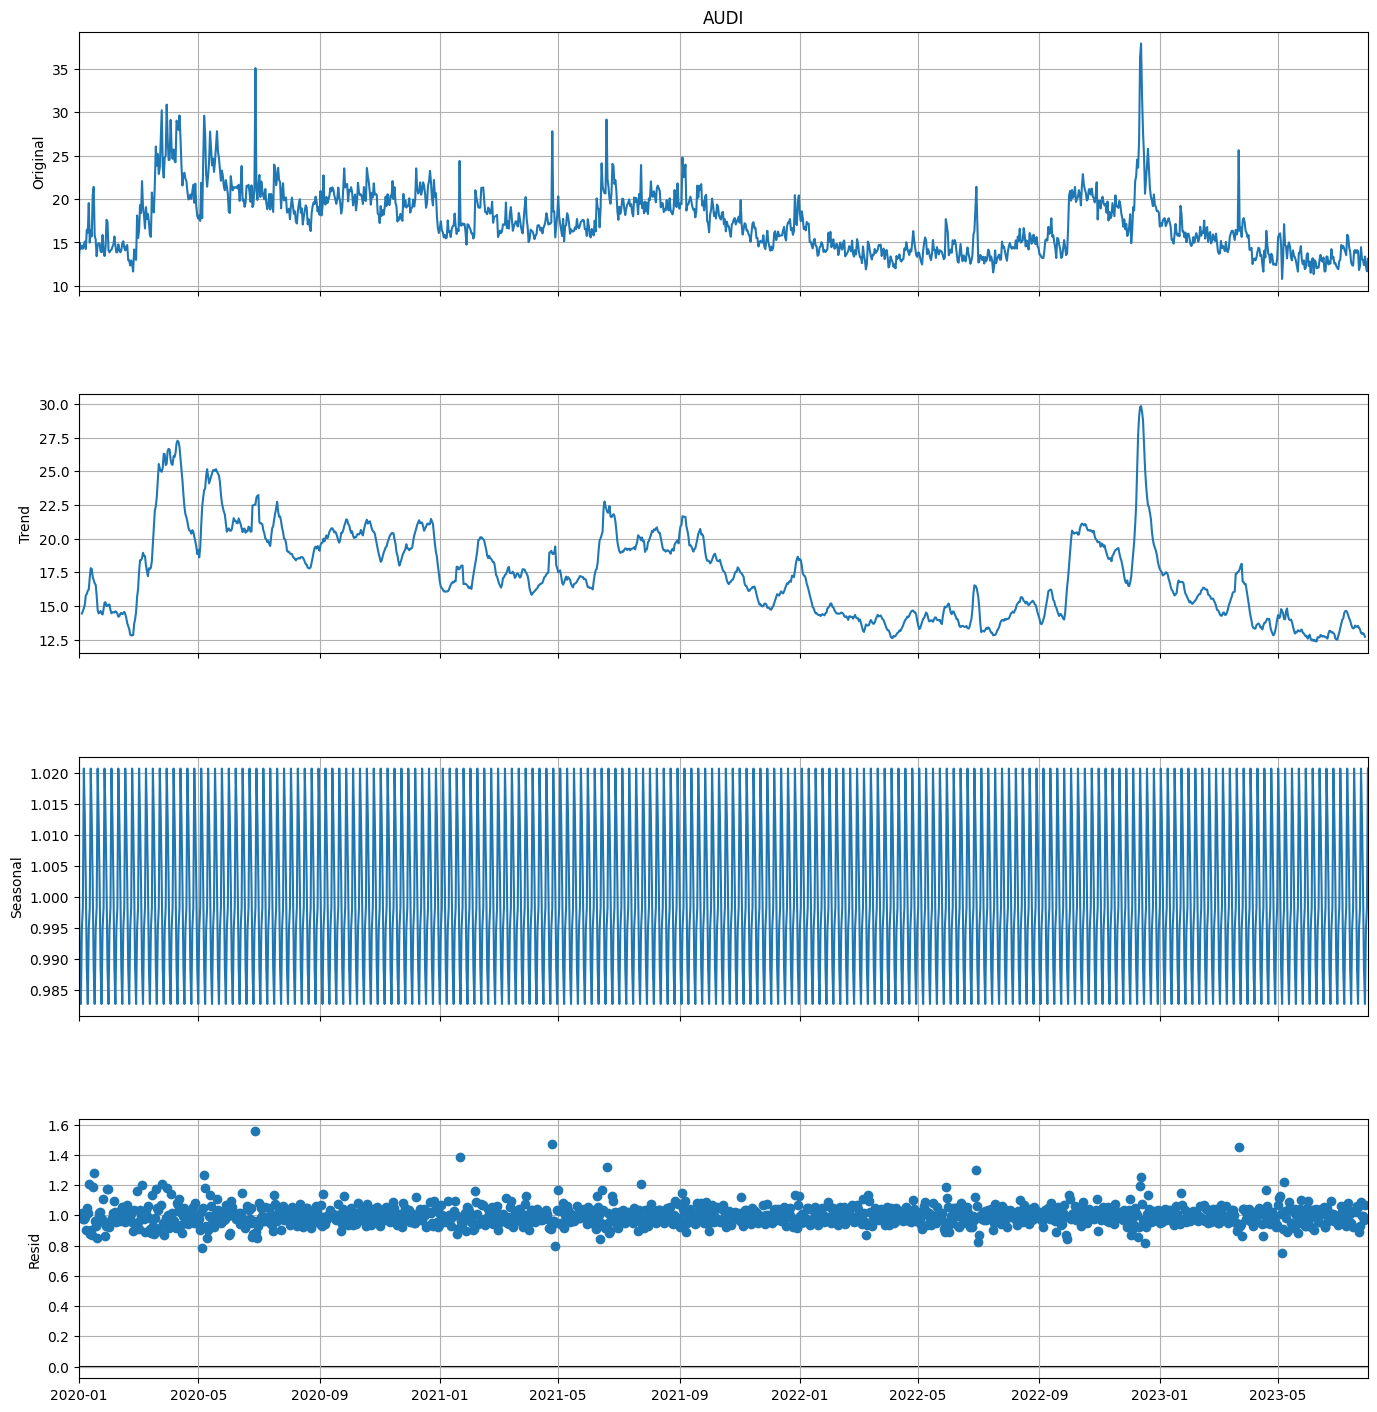

========= 원본 데이터 ===========
+------------------------------------+------------+
| ADF Test                           |            |
|------------------------------------+------------|
| 검정통계량(ADF Statistic)          |   -3.88715 |
| 유의수준(p-value)                  | 0.00213147 |
| 최적차수(num of lags)              |          5 |
| 관측치 개수(num of observations)   |       1302 |
| 기각값(Critical Values) 1%         |   -3.43538 |
| 기각값(Critical Values) 5%         |   -2.86376 |
| 기각값(Critical Values) 10%        |   -2.56795 |
| 데이터 정상성 여부(0=False,1=True) |          1 |
+------------------------------------+------------+


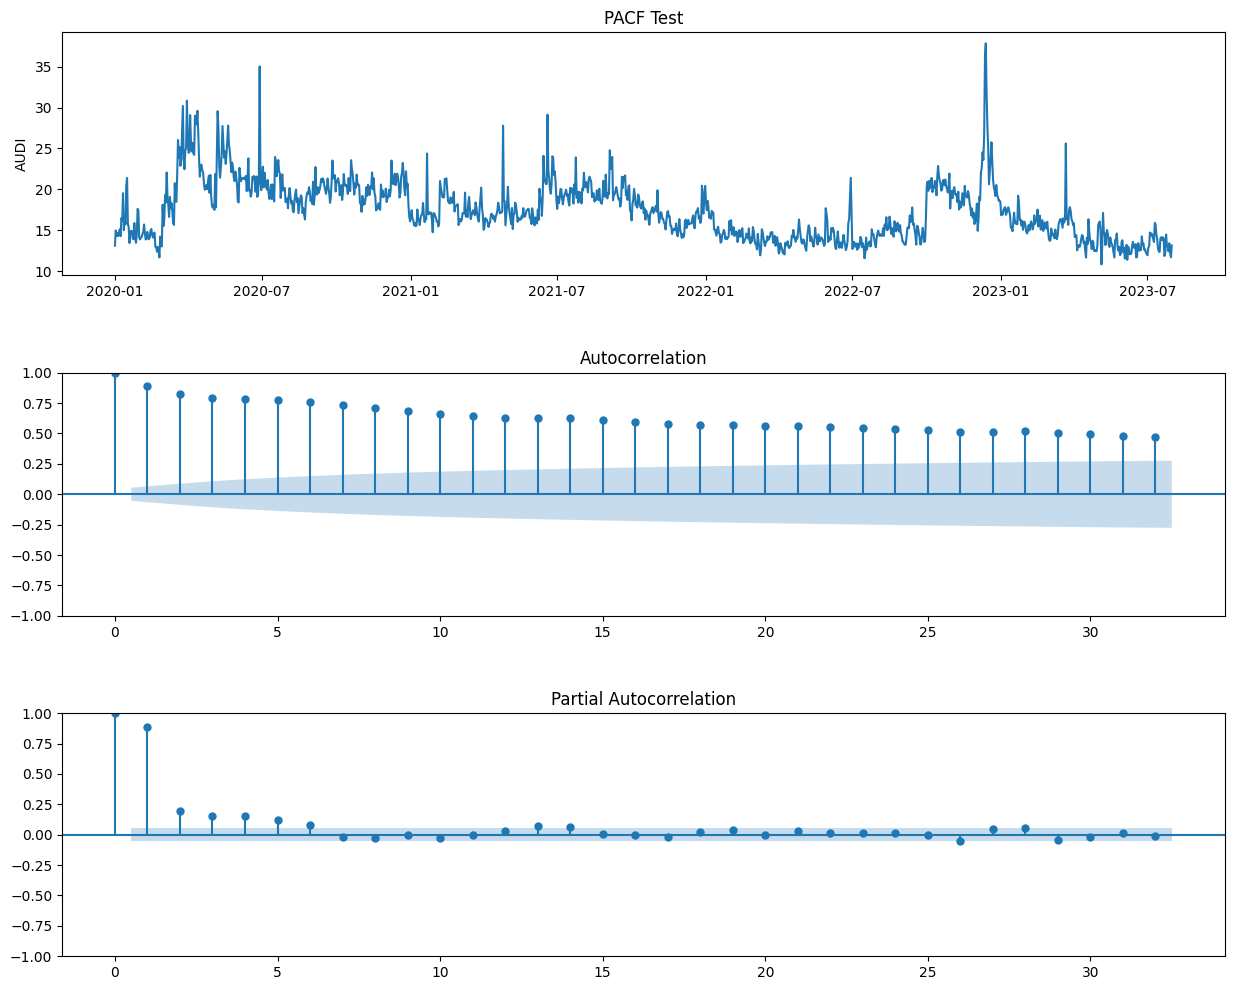

In [24]:
for c in df2.columns:
    print("====================")
    print(c)
    print("====================")

    exp_time_data(df2, c, 'm')

### ARIMA 분석수행

분석모델구성

C:\Users\hanjieun_2\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hanjieun_2\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hanjieun_2\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hanjieun_2\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49353 (\N{HANGUL SYLLABLE SAEG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hanjieun_2\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 4704

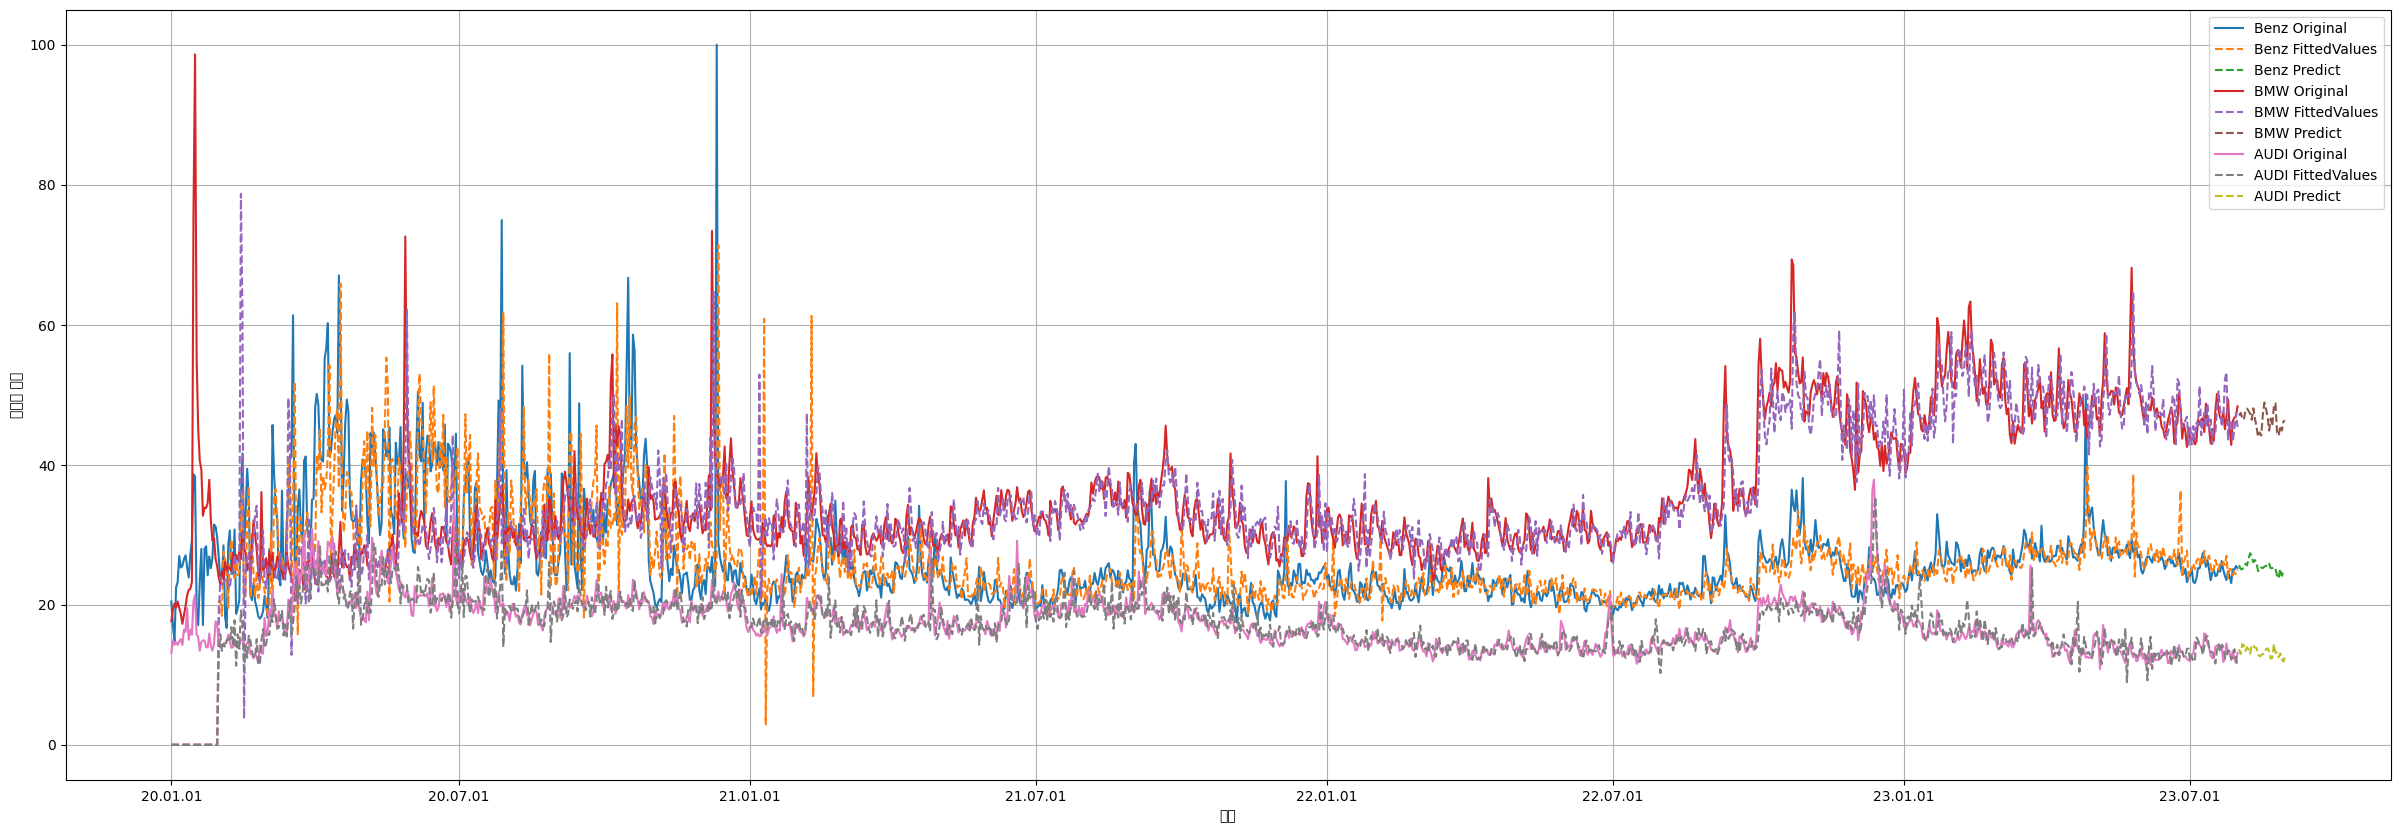

In [25]:
plt.figure(figsize=(30,10))

for c in df2.columns:
    # 모델 구성
    model = ARIMA(df2[c], order=(1,0,0), seasonal_order=(1,1,0,30))
    fit = model.fit()
    # 학습결과
    fv = fit.fittedvalues
    # 예측값
    fc = fit.forecast(30)

    sb.lineplot(data=df2, x=df2.index, y=c, label='%s Original' % c)
    sb.lineplot(x=fv.index, y=fv.values, label='%s FittedValues'% c, linestyle='--')
    sb.lineplot(x=fc.index, y=fc.values, label='%s Predict' % c, linestyle='--')

plt.xlabel('날짜')
plt.ylabel('검색량 비율')
plt.legend()

monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()